In [2]:
import os, sys

from pyspark.sql import SparkSession
from pyspark.sql import functions as f


In [3]:
import pyspark
print(pyspark.__version__)

4.1.1


In [204]:
# Force driver host/bind to localhost to avoid invalid hostname
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("StellarClassifier") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.port", "0") \
    .config("spark.pyspark.python", sys.executable) \
    .config("spark.pyspark.driver.python", sys.executable) \
    .config("spark.executorEnv.PYSPARK_PYTHON", sys.executable) \
    .getOrCreate()

print("master:", spark.sparkContext.master)
print("appName:", spark.sparkContext.appName)
print("spark.version:", spark.version)
spark.stop()

master: local[*]
appName: StellarClassifier
spark.version: 4.0.1


In [210]:
spark.stop()

In [4]:
# Initialize Spark and read CSV
spark = SparkSession.builder.master("local[*]").appName("StellarClassifier") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.port", "0") \
    .getOrCreate()
    # .config("spark.python.worker.faulthandler.enabled","true") \
    # .config("spark.sql.execution.pyspark.udf.faulthandler.enabled","true") \
    # .config("spark.pyspark.python", sys.executable) \
    # .config("spark.pyspark.driver.python", sys.executable) \
    # .config("spark.executorEnv.PYSPARK_PYTHON", sys.executable) \
    # .getOrCreate()

csv_path = "star_classification_org.csv"

# Read CSV with header and inferred schema
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Basic checks and preview
try:
    row_count = df.count()
except Exception as e:
    print("Could not count rows:", e)
    row_count = None

print(f"Loaded rows: {row_count} (path: {csv_path})")
df.printSchema()
df.show(10, truncate=False)

# Optional: try converting a small sample to pandas for quick inspection
try:
    pandas_df = df.limit(1000).toPandas()
    print("Converted to pandas, shape:", pandas_df.shape)
except Exception as e:
    print("Couldn't convert to pandas:", e)


Loaded rows: 100000 (path: star_classification_org.csv)
root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)

+---------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+---------------------+------+------------+-----+-----+--------+
|obj_ID               |alpha           |delta             |u    

In [4]:
df.select('obj_ID').distinct().count()

80846

In [5]:
df.describe().show()

+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|summary|              obj_ID|              alpha|            delta|                u|                 g|                 r|                 i|                 z|           run_ID|rerun_ID|           cam_col|          field_ID|         spec_obj_ID| class|          redshift|             plate|               MJD|         fiber_ID|
+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|  coun

## Dropping duplicate entries

In [5]:
df_unique = df.drop_duplicates(['obj_ID'])

In [6]:
df_unique.describe().show()

+-------+--------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|summary|              obj_ID|              alpha|             delta|                 u|                g|                 r|                 i|                 z|           run_ID|rerun_ID|           cam_col|          field_ID|         spec_obj_ID| class|          redshift|             plate|               MJD|         fiber_ID|
+-------+--------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|  c

# Choosing relevant features

u , g, r, i, z --

In [7]:
features = ["u", "g", "r", "i", "z"]
target = "class"
df_model = df_unique.select(target, *features)

In [8]:
df_model.show(5)

+------+--------+--------+--------+--------+--------+
| class|       u|       g|       r|       i|       z|
+------+--------+--------+--------+--------+--------+
|  STAR|20.79859|19.54183|19.04607|18.82743|18.74658|
|GALAXY|22.81235|21.48987|20.04629|19.59547|18.99735|
|GALAXY|22.44247|20.96329|20.00247|19.47096|19.38536|
|  STAR|23.17228|20.57825|19.14963|18.55397|18.15417|
|  STAR|19.84112|18.31459|17.70017|17.45584|17.36307|
+------+--------+--------+--------+--------+--------+
only showing top 5 rows


In [10]:
df_model.describe().show()

+-------+------+-----------------+-----------------+------------------+------------------+------------------+
|summary| class|                u|                g|                 r|                 i|                 z|
+-------+------+-----------------+-----------------+------------------+------------------+------------------+
|  count| 80846|            80846|            80846|             80846|             80846|             80846|
|   mean|  NULL|22.03626660490306|20.56915997155085|19.680593774212685| 19.10138325066171|18.652676720468605|
| stddev|  NULL|35.31733838847741|35.29880571367334|1.8561936364500249|1.7487185806570844|35.275939913258085|
|    min|GALAXY|          -9999.0|          -9999.0|           9.82207|          9.469903|           -9999.0|
|    max|  STAR|         30.66039|         31.60224|          29.57186|          30.25009|          28.23829|
+-------+------+-----------------+-----------------+------------------+------------------+------------------+



In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df_model_pd = df_model.toPandas()

In [13]:
for name in features:
    print(f"{name} bounds: {df_model_pd[name].min(), df_model_pd[name].max()}")

u bounds: (-9999.0, 30.66039)
g bounds: (-9999.0, 31.60224)
r bounds: (9.82207, 29.57186)
i bounds: (9.469903, 30.25009)
z bounds: (-9999.0, 28.23829)


## Verifying data distribution in pandas

In [14]:
df_model_pd[features] = df_model_pd[features].replace(-9999.0, float("nan"))

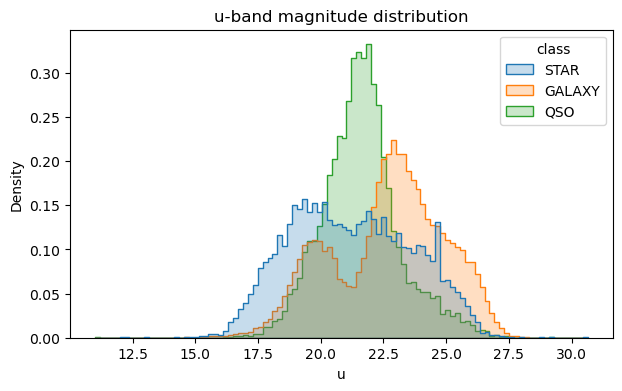

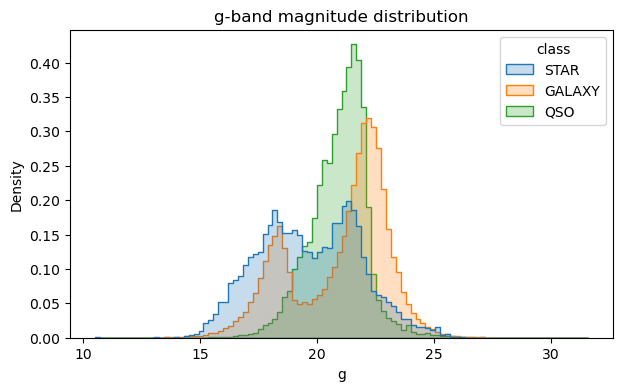

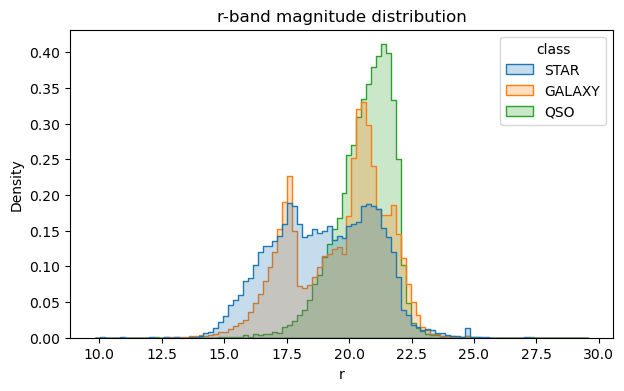

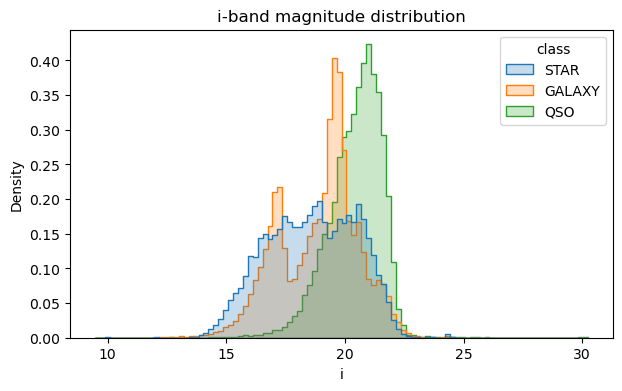

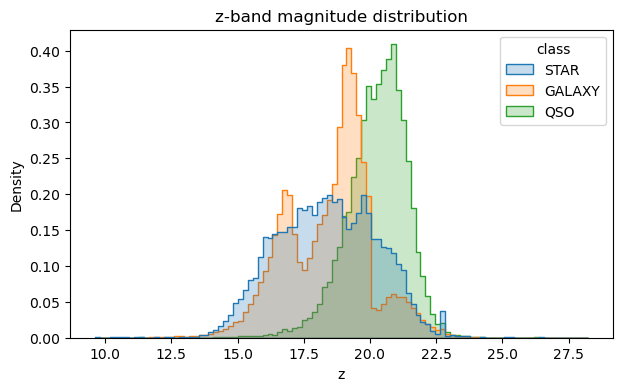

In [15]:
for name in features:
    plt.figure(figsize=(7,4))
    sns.histplot(
        data=df_model_pd,
        x=name,
        hue="class",
        bins=100,
        element="step",
        stat="density",
        common_norm=False
    )
    plt.title(f"{name}-band magnitude distribution")
    plt.show()

## Filtering the data

In [9]:
bad_value = -9999.0

df_model_clean = df_model.filter(
    " AND ".join([f"{c} != {bad_value}" for c in features])
)

In [17]:
df_model_clean.describe().show()

+-------+------+------------------+------------------+-----------------+------------------+------------------+
|summary| class|                 u|                 g|                r|                 i|                 z|
+-------+------+------------------+------------------+-----------------+------------------+------------------+
|  count| 80845|             80845|             80845|            80845|             80845|             80845|
|   mean|  NULL| 22.16022029735905|20.693095516853216|19.68061251369905|19.101396666868656|18.776588560121294|
| stddev|  NULL|2.2703838016516635| 2.051733249314542|1.856197468926587|1.7487252352653393|1.7523836424184578|
|    min|GALAXY|          10.99623|           10.4982|          9.82207|          9.469903|          9.612333|
|    max|  STAR|          30.66039|          31.60224|         29.57186|          30.25009|          28.23829|
+-------+------+------------------+------------------+-----------------+------------------+------------------+



## Adding additional features (colors)

In [10]:
from pyspark.sql.functions import col

df_model_clean = df_model_clean.withColumn("u_g", col("u") - col("g")) \
       .withColumn("g_r", col("g") - col("r")) \
       .withColumn("r_i", col("r") - col("i")) \
       .withColumn("i_z", col("i") - col("z"))

In [19]:
df_model_clean.describe().show()

+-------+------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|summary| class|                 u|                 g|                r|                 i|                 z|               u_g|               g_r|                r_i|                i_z|
+-------+------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|  count| 80845|             80845|             80845|            80845|             80845|             80845|             80845|             80845|              80845|              80845|
|   mean|  NULL| 22.16022029735905|20.693095516853216|19.68061251369905|19.101396666868656|18.776588560121294| 1.467124780505902|1.0124830031541845| 0.5792158468303557|0.32480810674748073|
| stddev|  NULL|2.2703838016516635| 2.051733249314542|1

In [11]:
features.extend(["u_g", "g_r", "r_i", "i_z"])

## Plotting the correlation matrix

In [21]:
df_model_clean_pd = df_model_clean.select(features).toPandas()

In [22]:
corr = df_model_clean_pd.corr()

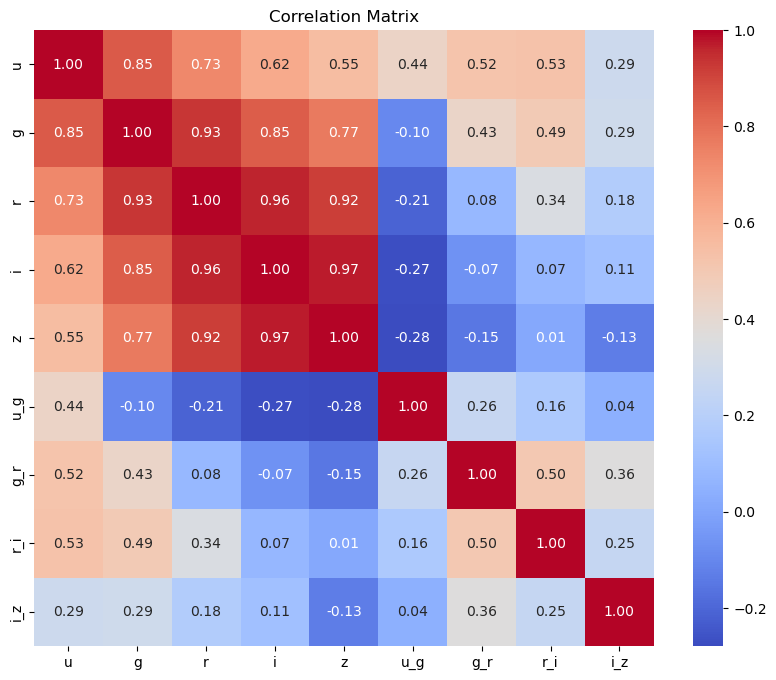

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Plotting class distribution

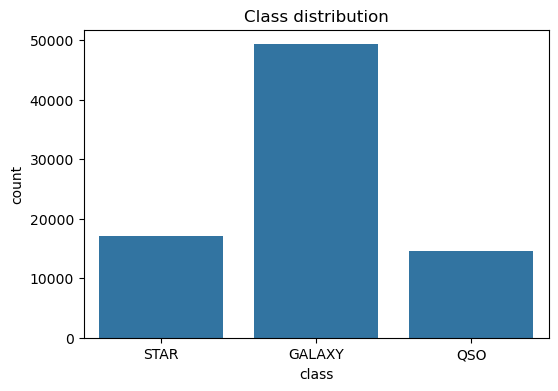

In [24]:
df_classes_pd = df_model_clean.select('class').toPandas()
plt.figure(figsize=(6,4))
sns.countplot(data=df_classes_pd, x="class")
plt.title("Class distribution")
plt.show()

## Undersampling

In [25]:
from pyspark.sql.functions import col
df_stars = df_model_clean.filter(col("class") == "STAR")
df_galaxies = df_model_clean.filter(col("class") == "GALAXY")
df_quasars = df_model_clean.filter(col("class") == "QSO")


In [26]:
print(f"number of instances:\nSTAR: {df_stars.count()}\nGALAXY: {df_galaxies.count()}\nQSO: {df_quasars.count()}")

number of instances:
STAR: 17021
GALAXY: 49269
QSO: 14555


In [27]:
df_stars = df_stars.sample(fraction=0.9)
df_galaxies = df_galaxies.sample(fraction=0.31)

In [28]:
print(f"number of resampled instances:\nSTAR: {df_stars.count()}\nGALAXY: {df_galaxies.count()}\nQSO: {df_quasars.count()}")

number of resampled instances:
STAR: 15319
GALAXY: 15238
QSO: 14555


In [29]:
df_model_clean_resampled = df_stars.union(df_galaxies).union(df_quasars)
df_model_clean_resampled.show(5)

+-----+--------+--------+--------+--------+--------+------------------+------------------+-------------------+-------------------+
|class|       u|       g|       r|       i|       z|               u_g|               g_r|                r_i|                i_z|
+-----+--------+--------+--------+--------+--------+------------------+------------------+-------------------+-------------------+
| STAR|23.17228|20.57825|19.14963|18.55397|18.15417|           2.59403|1.4286200000000022| 0.5956599999999987|0.39979999999999905|
| STAR|19.84112|18.31459|17.70017|17.45584|17.36307| 1.526530000000001|0.6144199999999991| 0.2443300000000015|0.09276999999999802|
| STAR|24.22564|21.13661|19.62566|  18.859|18.42587|3.0890299999999975|1.5109500000000011| 0.7666599999999981|  0.433130000000002|
| STAR| 24.9058| 21.5857|20.51728|18.95226|18.38489|            3.3201|1.0684199999999997| 1.5650200000000005| 0.5673700000000004|
| STAR|21.44778|18.84953|17.72303|17.27145|17.00578|           2.59825|            

## Deviding dataset on test and train sets

### Vectorizing

In [13]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

df_model_vec = assembler.transform(df_model_clean_resampled)

In [14]:
df_model_vec.show(5)

+------+--------+--------+--------+--------+--------+------------------+-------------------+------------------+-------------------+--------------------+
| class|       u|       g|       r|       i|       z|               u_g|                g_r|               r_i|                i_z|            features|
+------+--------+--------+--------+--------+--------+------------------+-------------------+------------------+-------------------+--------------------+
|  STAR|20.79859|19.54183|19.04607|18.82743|18.74658|1.2567599999999999|0.49576000000000064|0.2186400000000006|0.08084999999999809|[20.79859,19.5418...|
|GALAXY|22.81235|21.48987|20.04629|19.59547|18.99735|1.3224799999999988| 1.4435800000000008|0.4508200000000002|  0.598119999999998|[22.81235,21.4898...|
|GALAXY|22.44247|20.96329|20.00247|19.47096|19.38536|1.4791799999999995| 0.9608200000000018|0.5315099999999973|0.08560000000000301|[22.44247,20.9632...|
|  STAR|23.17228|20.57825|19.14963|18.55397|18.15417|           2.59403| 1.4286200

### Standardscaler

In [15]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,      # center the data
    withStd=True        # scale to unit variance
)

scaler_model = scaler.fit(df_model_vec)
df_scaled = scaler_model.transform(df_model_vec)

## Indexing classes

In [16]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCol="class",        # your column with "star", "galaxy", "quasar"
    outputCol="label_index"  # numeric labels
)
indexer_model = indexer.fit(df_scaled)
df_final = indexer_model.transform(df_scaled)

In [17]:
indexer_model.labels

['GALAXY', 'STAR', 'QSO']

In [18]:
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

## Plotting distribution of test and train data

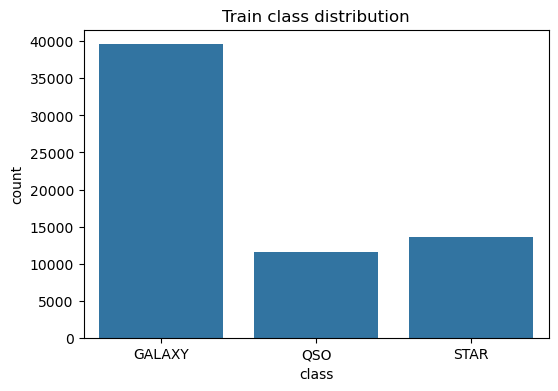

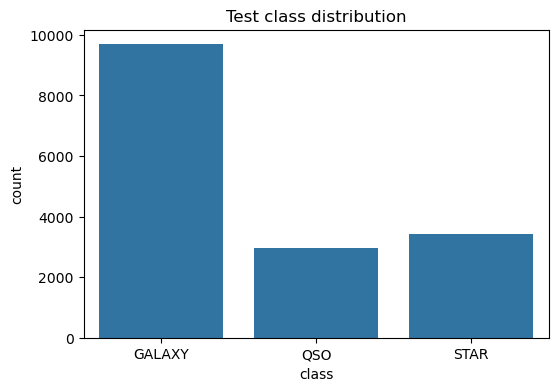

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df_pd = train_df.select("class").toPandas()
test_df_pd = test_df.select("class").toPandas()

plt.figure(figsize=(6,4))
sns.countplot(data=train_df_pd, x="class")
plt.title("Train class distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=test_df_pd, x="class")
plt.title("Test class distribution")
plt.show()

# Classification

In [21]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label_index"
)

model = clf.fit(train_df)
pred = model.transform(test_df)

In [38]:
pred.select("label_index", "prediction", "probability").show(20, truncate=False)

+-----------+----------+-------------------------------------------------------------+
|label_index|prediction|probability                                                  |
+-----------+----------+-------------------------------------------------------------+
|0.0        |0.0       |[0.9135409720747564,0.05505536373715807,0.0314036641880855]  |
|0.0        |0.0       |[0.5961534659640476,0.344362166515377,0.05948436752057532]   |
|0.0        |0.0       |[0.5898506774457575,0.20127762180198594,0.20887170075225656] |
|0.0        |0.0       |[0.9135409720747564,0.05505536373715807,0.0314036641880855]  |
|0.0        |0.0       |[0.9119500697624057,0.04811850452790279,0.039931425709691555]|
|0.0        |0.0       |[0.9119500697624057,0.04811850452790279,0.039931425709691555]|
|0.0        |0.0       |[0.9119500697624057,0.04811850452790279,0.039931425709691555]|
|0.0        |0.0       |[0.9135409720747564,0.05505536373715807,0.0314036641880855]  |
|0.0        |0.0       |[0.902240496556308,

In [22]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+----+----+
|label_index_prediction| 0.0| 1.0| 2.0|
+----------------------+----+----+----+
|                   0.0|9200| 208| 279|
|                   1.0|1037|1936| 441|
|                   2.0| 408| 232|2315|
+----------------------+----+----+----+



In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction"
)

accuracy = evaluator.setMetricName("accuracy").evaluate(pred)
precision = evaluator.setMetricName("weightedPrecision").evaluate(pred)
recall = evaluator.setMetricName("weightedRecall").evaluate(pred)
f1 = evaluator.setMetricName("f1").evaluate(pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8377553562531141
Precision: 0.8350647467457508
Recall: 0.8377553562531141
F1: 0.8304480124425433


## Neural Network

In [54]:
len(features)

9

In [52]:
features

['u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']

In [24]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [9, 20, 3]  # input, hidden, hidden, output

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label_index",
    layers=layers,
    maxIter=100
)

model = mlp.fit(train_df)
pred = model.transform(test_df)

In [62]:
pred.select("features").take(1)

[Row(features=DenseVector([14.2638, 12.036, 11.6417, 11.5153, 12.5513, 2.2278, 0.3943, 0.1264, -1.036]))]

In [63]:
pred

DataFrame[class: string, u: double, g: double, r: double, i: double, z: double, u_g: double, g_r: double, r_i: double, i_z: double, features: vector, scaled_features: vector, label_index: double, rawPrediction: vector, probability: vector, prediction: double]

In [64]:
pred.select("label_index", "prediction", "probability").show(20, truncate=False)


+-----------+----------+-------------------------------------------------------------+
|label_index|prediction|probability                                                  |
+-----------+----------+-------------------------------------------------------------+
|0.0        |0.0       |[0.7928786792162977,0.09811374796254557,0.10900757282115676] |
|0.0        |2.0       |[0.3920198844176756,0.04427699155511749,0.5637031240272069]  |
|0.0        |0.0       |[0.7331971112410594,0.06336507162916058,0.20343781712978007] |
|0.0        |0.0       |[0.7417021336187163,0.09321245300543729,0.16508541337584637] |
|0.0        |0.0       |[0.7443777339637239,0.06361757304960391,0.1920046929866721]  |
|0.0        |0.0       |[0.7479294417923669,0.06385180770486407,0.1882187505027691]  |
|0.0        |0.0       |[0.7320975059718653,0.06402926304454332,0.20387323098359145] |
|0.0        |0.0       |[0.7366062265144834,0.0749581028630728,0.18843567062244382]  |
|0.0        |0.0       |[0.7409776384857043

In [25]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+---+----+
|label_index_prediction| 0.0|1.0| 2.0|
+----------------------+----+---+----+
|                   0.0|9030|285| 372|
|                   1.0|1415|534|1465|
|                   2.0| 411|243|2301|
+----------------------+----+---+----+



In [26]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction"
)

accuracy = evaluator.setMetricName("accuracy").evaluate(pred)
precision = evaluator.setMetricName("weightedPrecision").evaluate(pred)
recall = evaluator.setMetricName("weightedRecall").evaluate(pred)
f1 = evaluator.setMetricName("f1").evaluate(pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.7389760837070254
Precision: 0.7111015412526757
Recall: 0.7389760837070254
F1: 0.7005466985609815


## Hyperparameters optimization

In [67]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label_index"
)
input_dim = 9
num_classes = 3

paramGrid = (ParamGridBuilder()
             .addGrid(mlp.layers, [
                 [input_dim, 20, num_classes],
                 [input_dim, 50, 20, num_classes],
                 [input_dim, 30, 30, num_classes],
                 [input_dim, 30, 20, 10, num_classes]
             ])
             .build())

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="f1"
)

cv = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = cv.fit(train_df)

In [68]:
best_model = cvModel.bestModel

In [70]:
best_model.layers

Param(parent='MultilayerPerceptronClassifier_c5405e0245a0', name='layers', doc='Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons.')

In [73]:
print("Best parameters chosen by CrossValidator:")
print(" layers     :", best_model.layers)
print(" maxIter    :", best_model.getMaxIter())
print(" blockSize  :", best_model.getBlockSize())
print(" stepSize   :", best_model.getStepSize())
print(" tol        :", best_model.getTol())

Best parameters chosen by CrossValidator:
 layers     : MultilayerPerceptronClassifier_c5405e0245a0__layers
 maxIter    : 100
 blockSize  : 128
 stepSize   : 0.03
 tol        : 1e-06


In [74]:
pred = best_model.transform(test_df)

In [75]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+----+----+
|label_index_prediction| 0.0| 1.0| 2.0|
+----------------------+----+----+----+
|                   0.0|1916| 746| 289|
|                   1.0| 282|2649|  77|
|                   2.0| 481| 307|2034|
+----------------------+----+----+----+



In [76]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction"
)

accuracy = evaluator.setMetricName("accuracy").evaluate(pred)
precision = evaluator.setMetricName("weightedPrecision").evaluate(pred)
recall = evaluator.setMetricName("weightedRecall").evaluate(pred)
f1 = evaluator.setMetricName("f1").evaluate(pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.751508939756292
Precision: 0.7578384276348796
Recall: 0.751508939756292
F1: 0.7495682084117976


In [81]:
best_model = cvModel.bestModel   # last stage is the MLP model
print(best_model.getLayers())

[9, 20, 3]


XGBoost

In [ ]:
from xgboost.spark import SparkXGBClassifier

xgb = SparkXGBClassifier(
    featuresCol="features",
    labelCol="label_index",
    numRound=200,
    maxDepth=6,
    eta=0.1
)

model = xgb.fit(train_df)
pred = model.transform(test_df)